In [1]:
%run ../cube/Cube.ipynb

Support algs imported!
Cube initiated


In [2]:
import json

In [3]:
@njit
def _inc_special(ids):
    for i in range(len(ids)):
        ids[i]+=1
        ids[i]%=9 # change based on number of moves
        if ids[i]:
            break
    return ids

@njit
def _is_valid_special(length,ids):
    for i in range(length-1):
        if ids[i]//3==ids[i+1]//3:
            return False
        # if ids[i]//6==ids[i+1]//6 and (ids[i]//3)%2:
        #     return False
    return True      

@njit
def _increment_special(length,ids):
    ids = _inc_special(ids)
    while not _is_valid_special(length,ids):
        ids = _inc_special(ids)
    return ids

length = 4
ids = np.array([0,3,6,0])
_increment_special(length,ids)


array([1, 3, 6, 0])

In [4]:
class alg_index_special:
    def __init__(self, length):
        '''
        length: int
        '''
        self.length = length
        self.moves = ["U","U'","U2","R","R'","R2","F","F'","F2"] # change to whatever you want to gen # ,"F","F'","F2"
        self.ids = np.array(([0,3,6]*int(length/3+1))[:length]) # change based on type of algs you gen
    
    def is_valid(self):
        return _is_valid_special(self.length,self.ids)
    
    def inc(self):
        ids = _inc_special(ids)
    
    def increment(self):
        self.ids = _increment_special(self.length,self.ids)
    
    def get_alg(self):
        scr = self.moves[self.ids[0]]
        for i in range(1,len(self.ids)):
            scr += f" {self.moves[self.ids[i]]}"
        return scr

# ai = alg_index_special(2)
# for i in range(500):
#     if ai.get_alg() == "F U":
#         print(ai.get_alg())
#     ai.increment()

In [388]:
def check_if_valid_alg(alg):
    '''
    check if valid alg
    how: make "alg index" of the alg and check _is_valid
    '''
    valid_moves = ["R","R'","R2","L","L'","L2","U","U'","U2","D","D'","D2","F","F'","F2","B","B'","B2"]
    moves = alg.split(" ")
    length = len(moves)
    ai = []

    for move in moves:
        move = move.upper()
        if move == "S":
            move = "B" # for now we'll just treat S as 
        if move == "S'":
            move = "B'"
        if move == "M":
            move = "L"
        if move == "M'":
            move = "L'"
        ai.append(valid_moves.index(move))

    return _is_valid(length,np.array(ai))


def gen_extra_algs(algs, insert_move, t = 0, print_time = True):
    # note: this can gen R L and L R, should force only one order

    extra_algs = []
    k = 0
    for a, alg in enumerate(algs):
        moves = alg.split(" ")[:-1] # we don't want the last move, since we're inserting a move after it

        if 100*a//len(algs)>k:
            k += 1
            print(f"{k}% done in {time.time()-t}")

        for i in range(len(moves)+1):
            new_alg = ""
            for j in range(len(moves)+1):
                # make alg again, but insert insert_move between place j-1 and j
                if i == j < len(moves):
                    new_alg += insert_move + " " + moves[j] + " "
                elif j < len(moves):
                    new_alg += moves[j] + " "
                elif i == j: # j == len(moves) and i == j means we add insert_move to the end
                    new_alg += insert_move

            app_alg = new_alg.strip()
            if check_if_valid_alg(app_alg) and app_alg not in extra_algs:
                extra_algs.append(app_alg)
    return extra_algs


def alg_good(alg):
    # we assume the alg is valid, that is no two moves in a row are on the same face, so we don't check that
    # returns true if alg is good, false if it's bad
    # we just make some rules for what makes an alg bad

    # rule 1: max 1 F2
    if alg.count("F2") > 1:
        return False
    # rule 2: max 2 double moves
    if alg.count("2") > 2:
        return False
    # rule 3: score_alg/count_moves(alg)

    if score_alg(alg)/count_moves(alg) > 2:
        return False

    return True


def gen_algs(n, min_length = 1, print_time = True, remove_bad = True):

    algs = []

    t = time.time()

    for i in range(min_length - 1, n):
        ai = alg_index_special(i+1)
        start_alg = ai.get_alg()

        algs.append(start_alg)
        ai.increment()

        while start_alg != ai.get_alg():
            if remove_bad and not alg_good(ai.get_alg()):
                ai.increment()
                continue
            algs.append("f "+ai.get_alg())
            ai.increment()

        if print_time:
            print(f"Algs of length {i+1} genned after {round(time.time()-t,3)}s")
    
    return algs

def insert_move(algs, insert_move, invert = True, print_time = True):
    t = time.time()
    # if insert_move is set to a move
    if insert_move:
        if print_time:
            print(f"Inserting extra move")
        extra_algs = gen_extra_algs(algs, insert_move, t, print_time)
        if invert:
            if print_time:
                print(f"Extra move inserted after {round(time.time()-t,3)}s. Inserting inverse of extra move.")
            extra_algs += gen_extra_algs(algs, inverse_alg(insert_move), t, print_time)
            print(f"Extra inverse move added after {round(time.time()-t,3)}s")

        algs += extra_algs
    return algs

algs = gen_algs(6)
print(len(algs))
# algs = insert_move(algs, "r", invert = True)
# algs = insert_move(algs, "S", invert = True)
# algs = insert_move(algs, "f", invert = True)
# algs = insert_move(algs, "D", invert = True)
# algs = insert_move(algs, "M", invert = True)
# algs = insert_move(algs, "F", invert = True)
print(len(algs))

Algs of length 1 genned after 0.0s
Algs of length 2 genned after 0.0s
Algs of length 3 genned after 0.002s
Algs of length 4 genned after 0.013s
Algs of length 5 genned after 0.079s
Algs of length 6 genned after 0.394s
32842
32842
['U', "f U'", 'f U2', 'f R', "f R'", 'f F', "f F'", 'f F2', 'U R', "f U' R"]


In [389]:
def gen_table(algs):
    '''
    Gen dictionary with keys being cases reached by inverting each alg, with dict[case] = alg
    '''
    table = {}

    for alg in algs:
        inv = inverse_alg(alg)
        # skip algs ending with U* as the first move is equivalent to a AUF
        if alg[0]=="U":
            continue

        cube = Cube(2) # only F2L
        cube.apply_moves(alg)
        case = id_from_state(cube.state)

        if case not in table.keys():
            table[case] = [inv]
        else:
            table[case] += [inv]

    return table

table = gen_table(algs)
len(table)

29751

In [390]:
def gen_LL_algs(algs, table, bridge = "", print_time = True):
    '''
    gens LL algs using algs as premoves and the table to finish the algs
    '''
    LL_algs = []

    j = 0
    t = time.time()
    for i, premove in enumerate(algs):
        if premove[0] == "U":
            continue

        # add extra alg
        if bridge:
            premove = cancel_alg(premove + " " + bridge)

        if 10*i//len(algs)>j:
            j += 1
            print(f"{10*j}% done in {time.time()-t}")

        cube = Cube(2)
        cube.apply_moves(premove)

        case = id_from_state(cube.state)
        if case in table:
            for finish in table[case]:
                new_alg = cancel_alg(premove + " " + finish)

                # append alg if it's not empty ("") and it doesn't exist already (duplicates from cancling moves for example)
                if new_alg and new_alg not in LL_algs: 
                    LL_algs.append(new_alg)
    
    return LL_algs

In [391]:
def score_alg(alg):
    return len(alg.split(" "))*2 + alg.count("R2")*0.5

def sort_algs(algs):
    '''
    sort into dictionary based on which case the alg solves
    '''
    LL_algs_dict = {}
    for alg in algs:
        ID = 0
        for u1 in ["", "U ", "U2 ", "U' "]:
            for u2 in ["", " U", " U2", " U'"]:
                u_alg_u = u1+alg+u2
                cube = Cube()
                cube.apply_moves(u_alg_u)

                case = id_from_state(cube.state)
                if case in LL_algs_dict:
                    ID = case
        if ID:
            LL_algs_dict[ID] += [alg]
        else:
            cube = Cube()
            cube.apply_moves(alg)
            ID = id_from_state(cube.state)
            LL_algs_dict[ID] = [alg]

    # sort the lists in the dict according to length of algs
    sorted_dict = {key: sorted(value, key=score_alg) for key, value in LL_algs_dict.items()}
    
    return sorted_dict

In [392]:
def score_key(key):
    return score_alg(LL_algs_dict[key][0])

In [393]:
def zblls_only(LL_algs_dict):
    '''
    remove all algs that are not zblls
    '''
    new_dict = {}
    for key, algs in LL_algs_dict.items():
        cube = Cube()
        cube.apply_moves(algs[0])
        case_edges = id_from_state(cube.state,np.array([37,39,40,41,43]))

        if case_edges == "55555":
            new_dict[key] = algs
    return new_dict

In [394]:
# dictionary of all cases we reach by applying the alg backwards to a cube in state 3
olls_dict = {
    "pll": ['000111111000222222000333333000444444555555555666666666'],
    "sune": ['005111111005222222005333333000444444050555550666666666', '005111111005222222000333333005444444550555050666666666', '005111111000222222005333333005444444055555050666666666', '000111111005222222005333333005444444050555055666666666'],
    "antisune": ['500111111500222222000333333500444444055555050666666666', '500111111000222222500333333500444444050555055666666666', '000111111500222222500333333500444444050555550666666666', '500111111500222222500333333000444444550555050666666666'],
    "pi": ['005111111000222222500333333505444444050555050666666666', '000111111500222222505333333005444444050555050666666666', '500111111505222222005333333000444444050555050666666666', '505111111005222222000333333500444444050555050666666666'],
    "H": ['000111111505222222000333333505444444050555050666666666', '505111111000222222505333333000444444050555050666666666'],
    "L": ['500111111005222222000333333000444444550555055666666666', '005111111000222222000333333500444444055555550666666666', '000111111000222222500333333005444444550555055666666666', '000111111500222222005333333000444444055555550666666666'],
    "T": ['500111111000222222005333333000444444055555055666666666', '000111111005222222000333333500444444050555555666666666', '005111111000222222500333333000444444550555550666666666', '000111111500222222000333333005444444555555050666666666'],
    "U": ['505111111000222222000333333000444444555555050666666666', '000111111000222222000333333505444444055555055666666666', '000111111000222222505333333000444444050555555666666666', '000111111505222222000333333000444444550555550666666666']
}

# invert the olls_dict
oll_dict_ = {}
for key, value in olls_dict.items():
    for v in value:
        oll_dict_[v] = key

def categorize_zblls(zblls):
    '''
    For each item in zblls, apply the first alg backwards to a cube in state 3, and check which subset it belongs to
    Then append the key and value to a new dictionary which is a subset of a new dictionary
    '''
    new_dict = {}
    for key, algs in zblls.items():
        cube = Cube(3)
        cube.apply_moves(inverse_alg(algs[0]))
        case = id_from_state(cube.state)
        if case in oll_dict_:
            if oll_dict_[case] in new_dict:
                new_dict[oll_dict_[case]][key] = algs
            else:
                new_dict[oll_dict_[case]] = {key: algs}
        else:
            print(f"Case {case} not in oll_dict")

    return new_dict

LL_algs = gen_LL_algs(algs, table, bridge = "R U R' U'", print_time = True)
print(len(LL_algs))
LL_algs_dict = sort_algs(LL_algs)
print(len(LL_algs_dict))
LL_keys = list(LL_algs_dict.keys())
sorted_LL_keys = sorted(LL_algs_dict, key = score_key)
zblls = zblls_only(LL_algs_dict)
print(len(zblls))
zbll_keys = list(zblls.keys())
sorted_zblls_keys = sorted(zblls, key = score_key)
zblls_categorized = categorize_zblls(zblls)
# print the keys for zblls_categorized so we know which cases we have genned algs for
print("Algs genned:")
# print the length of each subset
for key, value in zblls_categorized.items():
    print(f"  {key} - {len(value)}")


10% done in 0.12070369720458984
20% done in 0.20722079277038574
30% done in 0.29561519622802734
40% done in 0.3916661739349365
50% done in 0.4850163459777832
60% done in 0.5976128578186035
70% done in 0.697484016418457
80% done in 0.8149588108062744
90% done in 0.9350931644439697
1160
667
122
Algs genned:
  T - 20
  L - 24
  sune - 16
  pll - 8
  H - 5
  U - 27
  antisune - 15
  pi - 7


In [395]:
# decide which subset to look at
# subsets: pll, sune, antisune, pi, H, L, T, U
subset = "pll"
sorted_subset_keys = sorted(zblls_categorized[subset], key = score_key)
print(len(zblls_categorized[subset]))
i = -1

8


In [404]:
# i -= 2 # -1 overall 
i += 1

key = sorted_subset_keys[i]
algs_LL = zblls_categorized[subset][key]
cube = Cube()
cube.apply_moves(inverse_alg(algs_LL[0]))
cube.plot()

print(i) 
for j, alg in enumerate(algs_LL):
    print(f"{j+1}. {alg} ({len(alg.split(' '))})")

IndexError: list index out of range

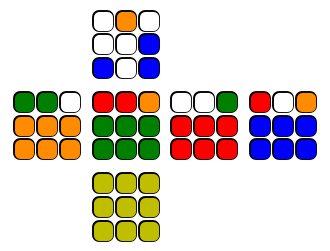

28
1. f U' R' U2 R' U2 R2 U R' f' (10)


In [435]:
# i = -1
# i -= 2
i += 1

key = sorted_LL_keys[i]
algs_LL = LL_algs_dict[key]
cube = Cube()
cube.apply_moves(inverse_alg(algs_LL[0]))
cube.plot()

print(i)
for j, alg in enumerate(algs_LL):
    print(f"{j+1}. {alg} ({len(alg.split(' '))})")

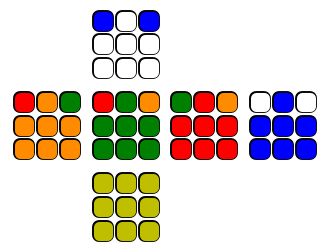

"F' R' F2 U2 r' D'"

In [604]:
new_alg = "F R U' R' U' R U2 R' U' R U' R' U' R U2 R' U' F'"
# new_alg = "R' U R U R' F' R U R' U' R' F R2 U' R' U2 R U' R' U2 R"
# new_alg = "R' U' R U' R' U2 R2 U2 L' U R' U' L U' R U' R'"
# new_alg = "R U R D R' U2 R D' R' U' R' U R U' R' U' R U' R'"

cube = Cube()
cube.apply_moves(new_alg)
cube.plot()

case_id = id_from_state(cube.state)

algs[-1]

In [606]:
def check_if_case(alg, case):
    for u1 in ["", "U ", "U2 ", "U' "]:
        for u2 in ["", " U", " U2", " U'"]:
            u_alg_u = u1+alg+u2
            cube = Cube()
            cube.apply_moves(u_alg_u)

            case_id = id_from_state(cube.state)
            if case_id == case:
                return True
    return False


def find_specific_case(case_id, algs, table, bridge = "", print_time = True): # TODO: add so it also looks for opposite case, and just invert the alg
    '''
    gens LL algs using algs as premoves and the table to finish the algs
    '''
    case_algs = []

    j = 0
    t = time.time()
    for i, premove in enumerate(algs):
        if premove[0] == "U":
            continue

        # add extra alg
        if bridge:
            premove = cancel_alg(premove + " " + bridge)

        if 10*i//len(algs)>j:
            j += 1
            print(f"{10*j}% done in {time.time()-t}")

        cube = Cube(2)
        cube.apply_moves(premove)

        case = id_from_state(cube.state)
        if case in table:
            for finish in table[case]:
                new_alg = cancel_alg(premove + " " + finish)

                # append alg if it's not empty ("") and it doesn't exist already (duplicates from cancling moves for example)
                if new_alg and check_if_case(new_alg, case_id):
                    case_algs.append(new_alg)
    
    return case_algs

case_algs = find_specific_case(case_id, algs, table, bridge = "D' r U' r' D", print_time = True)
for alg in case_algs:
    print(f"{alg} ({len(alg.split(' '))})")


10% done in 0.39534997940063477
20% done in 0.7755117416381836
30% done in 1.1906659603118896
40% done in 1.7267179489135742
50% done in 2.082810640335083
60% done in 2.456770181655884
70% done in 2.9528427124023438
80% done in 3.3325576782226562
90% done in 3.7366702556610107


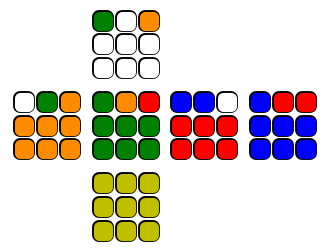

In [34]:
cube = Cube()
cube.apply_moves(inverse_alg("R' F' U' F U D' r U' r' D R F' U F"))
cube.plot()

In [ ]:
triggers = ["R U R' U'", "F R U R' U' F'", "D' R U R' D", "D' R U' R' D", "D' R U2 R' D", "D' r U r' D", "D' r U2 r' D", "S R' U' R U R S'", "S' R U R' S", "S' R U' R' S", "S' R U2 R' S"]